# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [271]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

### Реализовал MyDBSCAN

In [272]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Кластеризация набора данных data_set с помощью алгоритма DBSCAN.

    Принимает набор данных data_set (список векторов), пороговое расстояние
    `eps`, и необходимое минимальное количество точек для формирования плотной области `min_pts`.

    Он возвращает список меток кластера.
    Метки:
     -1 означает шум, кластеры нумеруются начиная с 1.

    eps - минимальное расстояние между двумя точками. Это означает, что если расстояние между двумя точками
          меньше или равно этому значению (eps), то эти точки считаются соседями.

    min_pts - минимальное количество точек для формирования плотной области.
                Например, если установить параметр minPoints равным 5,
                то для формирования плотной области потребуется не менее 5 точек.
    """

    def __init__(self, eps=0.5, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts
        self.labels = None
        return

    def fit(self, X, y=None):
        """
        Этот список будет содержать окончательное назначение кластера для каждой точки датасета X (data_set).
        Есть два зарезервированных значения:
        -1 - указывает на точку шума
        0 - означает, что точка еще не рассмотрена.
        Изначально все метки равны 0 (точки еще не рассмотрена)
        """
        labels = [0] * len(X)

        """
         "C" - изначальное значение ID для датасета
        """
        C = 0

        """
        Этот внешний цикл отвечает только за сбор новых начальных точек
        Точки из которого вырастет новый кластер.

        Как только допустимая начальная точка найдена,
        создается новый кластер и рост кластера обрабатывается процедурой expandCluster.
        """

        """
        Для каждой точки point_index в наборе данных X...
        ('point_index' - это индекс точки данных, а не сама точка данных.)
        """
        for point_index in range(0, len(X)):
            """
            В качестве новых начальных точек можно выбрать только те, которые еще не были заявлены.
            Если метка точки не равна 0, перейдите к следующей точке.
            """
            if not (labels[point_index] == 0):
                continue

            # Найдите все соседние точки point_index.
            neighbor_points = self.region_query(X, point_index)

            """
            Если номер под min_pts, то этот пункт шум.

            Если количество соседей "neighbor_points" меньше заданного "min_pts" помечаем как шум.

            Это единственное условие, при котором точка помечается
            Шум, когда это не допустимая начальная точка. Точка шума может позже
            быть выбранным другим кластером в качестве граничной точки (это единственный
            условие, при котором метка кластера может измениться-от шума до
            что-то другое).
            """
            if len(neighbor_points) < self.min_pts:
                labels[point_index] = -1
            else:
                """
                В противном случае, если поблизости есть хотя бы min_pts, используйте эту точку в качестве семени для нового кластера.
                """

                # Получите следующую метку кластера.
                C += 1

                # Назначтм метку нашей начальной точке.
                labels[point_index] = C

                # Вырастите кластер из начальной точки.
                self.grow_cluster(X, labels, point_index, C)

        # return labels
        self.labels = labels
        return self
        # self.x_len = len(x)
        # return self

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.labels

    def grow_cluster(self, data_set, labels, point_index, C):
        """
        Вырастить новый кластер с меткой `C` с point_index исходная точка``.

        Эта функция выполняет поиск по набору данных, чтобы найти все точки, которые принадлежат
        в этот новый кластер. Когда эта функция возвращается, кластер `C` завершен.

        Параметры:
          `data_set` - набор данных (список векторов)
          `labels` - список меток кластера для всех точек набора данных
          `point_index` - индекс начальной точки для нового кластера
          `C` - метка для этого нового кластера.
          `eps` - пороговое расстояние
          `min_pts` - минимальное количество соседей
        """

        """
        SearchQueue - это очередь точек FIFO для оценки.
        Помещаються только точки которые принадлежат кластеру C 
        или уже были помечены как при принадлежащие данному кластеру.
        """

        """
        Точки представлены их индексными значениями.
        """

        """
        Поведение очереди FIFO выполняется путем добавления новых точек в конец списка
        и использования цикла while, а не цикла for.
        """
        SearchQueue = [point_index]

        """
        Для каждой точки в очереди:
        1. Определите, является ли это ветвью или "листом"
        2. Для точек ветвей добавьте их невостребованные соседи в очередь поиска
        """
        i = 0
        while i < len(SearchQueue):
            # Получить следующую точку из очереди.
            point_index = SearchQueue[i]

            # Найти все соседи индекса "point_index"
            neighbor_points = self.region_query(data_set, point_index)

            """
            Если количество соседей ниже минимума ( min_pts ), то это конечная точка, и мы переходим к следующей точке в очереди.
            """
            if len(neighbor_points) < self.min_pts:
                i += 1
                continue

            """
            Иначе у нас есть минимальное количество соседей, и это точка ветвления.
            """
            # Для каждого из соседей...
            for Pn in neighbor_points:
                """
                Если Pn был обозначен шум во время поиска, то мы знайте,
                что это не точка ветвления (у нее недостаточно соседей),
                поэтому сделайте ее конечной точкой кластера C и двигайтесь дальше.
                """
                if labels[Pn] == -1:
                    labels[Pn] = C
                elif labels[Pn] == 0:
                    """
                    В противном случае, если Pn еще не заявлен, заявите его как часть C и добавьте в очередь поиска.
                    """
                    labels[Pn] = C
                    SearchQueue.append(Pn)

            # Переход к следующей точке в очереди FIFO.
            i += 1

            # Мы закончили выращивать кластер с!

    def region_query(self, data_set, point_index):
        """
        Найти все точки в наборе данных "data_set" на расстоянии "eps" в точки "point_index".

        1. Эта функция вычисляет расстояние между точкой "point_index" и любым другим
        точки в наборе данных,
        2. Возвращает только те точки, которые находятся в пороговое расстояние `eps`.
        """

        neighbors = []
        # Для каждой точки в наборе данных выполняем ...
        for Pn in range(0, len(data_set)):
            if Pn == point_index:
                continue

            # Если расстояние ниже порога, добавьте его в список соседей.
            if np.linalg.norm(data_set[point_index] - data_set[Pn]) <= self.eps:
                neighbors.append(Pn)

        return neighbors

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

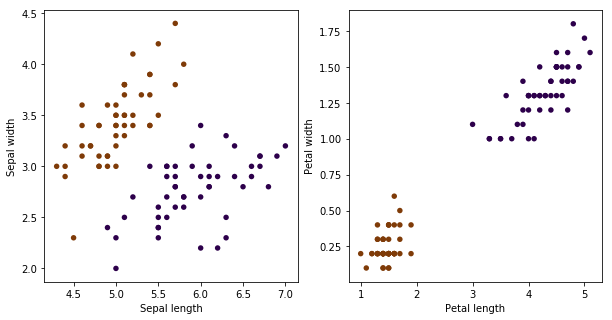

In [273]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [274]:
pred_iris = Clustering(eps=0.8, min_pts=6).fit_predict(x_iris) 
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

## ДЗ.

### Согласно алгоритму по ссылке https://habr.com/ru/post/322034/

**1.** Выберите m. Обычно используются значения от 3 до 9, чем более неоднородный
ожидается датасет, и чем больше уровень шума, тем большим следует взять.

**2.** Вычислите среднее расстояние по  ближайшим соседям для каждой точки.
Т.е. если , нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.

**3.** Сортируем полученные значения по возрастанию и выводим на экран.

**4.** Видим что-то вроде возрастающего графика. Следует взять  где-нибудь в полосе, где происходит самый сильный перегиб. Чем больше, тем больше получатся кластеры, и тем меньше их будет.

#### Количество соседей с 7 до 10

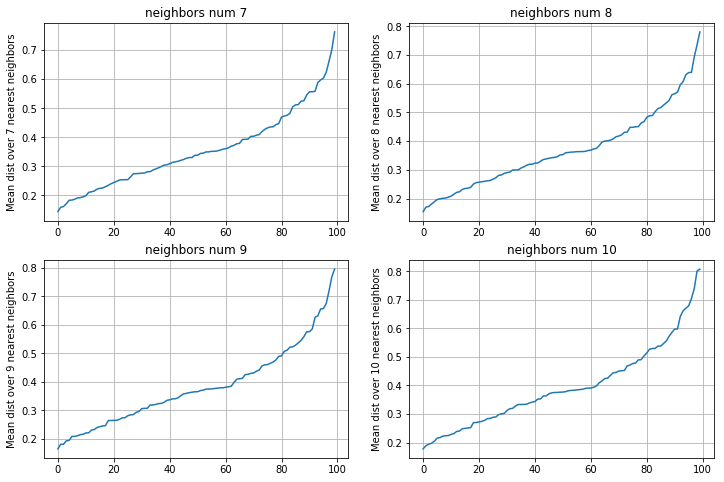

In [275]:
fig, axes = plt.subplots(nrows=2, ncols=2)

n_neighbors = 6
for row_ax in axes:
    for current_ax in row_ax:
        n_neighbors += 1
        
        distances, indices = nbrs.kneighbors(n_neighbors=n_neighbors)
        average_distances = distances.sum(axis=1)/n_neighbors
        average_distances_sort = np.sort(average_distances)
        
        current_ax.plot(lens, average_distances_sort)
        current_ax.set_title('neighbors num {}'.format(n_neighbors))
        current_ax.set_ylabel("Mean dist over {} nearest neighbors".format(n_neighbors))
        current_ax.grid()

#### Количество соседей с 11 до 14

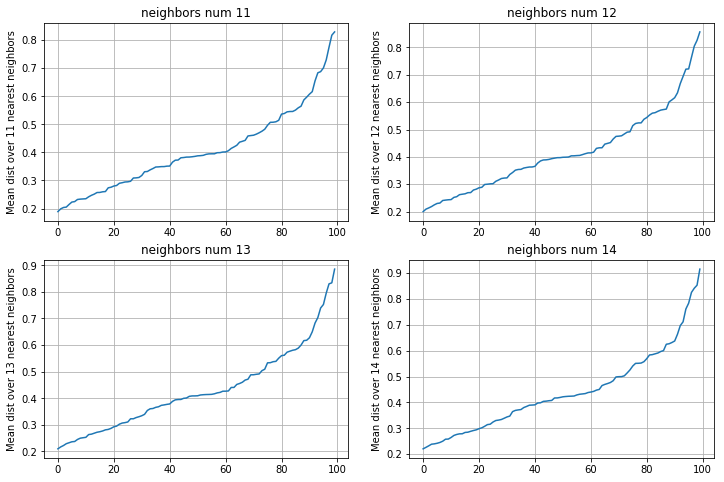

In [276]:
fig, axes = plt.subplots(nrows=2, ncols=2)

n_neighbors = 10
for row_ax in axes:
    for current_ax in row_ax:
        n_neighbors += 1
        distances, indices = nbrs.kneighbors(n_neighbors=n_neighbors)
        average_distances = distances.sum(axis=1)/n_neighbors
        average_distances_sort = np.sort(average_distances)
        
        current_ax.plot(lens, average_distances_sort)
        current_ax.set_title('neighbors num {}'.format(n_neighbors))
        current_ax.set_ylabel("Mean dist over {} nearest neighbors".format(n_neighbors))
        current_ax.grid()

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

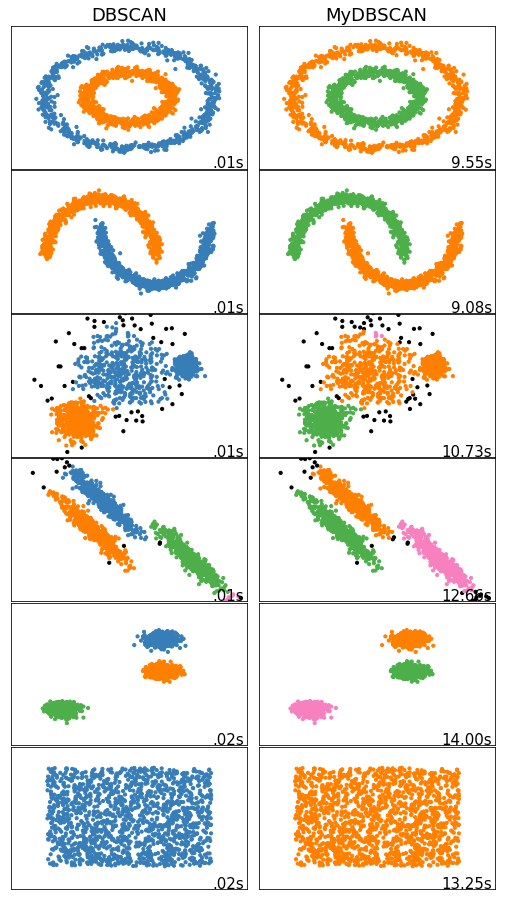

In [283]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(2 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
# plt.subplots_adjust(left=.02, right=.9, bottom=.001, top=5.99, wspace=.05,
#                       hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    dbscan = cluster.DBSCAN(eps=params['eps'])
    my_dbscan = Clustering(eps=params['eps'])
    #     my_dbscan = Clustering(eps=0.3, min_pts=6)

    clustering_algorithms = (
        ('DBSCAN', dbscan),
        ('MyDBSCAN', my_dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.fit_predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.